In [1]:
# 1 - Data labeling

import numpy as np
import cv2
import os
from tqdm import tqdm

IMAGE_SIZE = (150, 150)

# 데이터 로드
def load_data(data_dir):
    dataset = 'train'
    images = []
    labels = []

    # 클래스 이름과 라벨을 얻기
    class_names_label = {name: idx for idx, name in enumerate(os.listdir(os.path.join(data_dir, dataset)))}

    print("{} 데이터 로드 중".format(dataset))

    dataset_path = os.path.join(data_dir, dataset)

    # 각 카테고리에 해당하는 폴더를 순회
    for folder in os.listdir(dataset_path):
        label = class_names_label[folder]

        # 폴더 안의 각 이미지를 순회
        folder_path = os.path.join(dataset_path, folder)
        for file in tqdm(os.listdir(folder_path)):
            # 이미지의 경로 이름을 얻기
            img_path = os.path.join(folder_path, file)

            # 이미지 열기 및 리사이즈
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # 이미지와 해당 라벨을 출력 리스트에 추가
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    return images, labels, class_names_label

# 데이터셋 경로 설정
data_dir = "C:/Coding/Python/machine_learning/term_project"

# 데이터 로드
images, labels, class_names_label = load_data(data_dir)

# 확인 출력
print(f'Images data : {images.shape}, dtype = {images.dtype}')
print(f'Images category : {labels.shape}, dtype = {labels.dtype}')


train 데이터 로드 중


100%|██████████| 40/40 [00:00<00:00, 1524.65it/s]

Images data : (200, 150, 150, 3), dtype = float32
Images category : (200,), dtype = int32


Images size : (600, 150, 150, 3), dtype = int32
Train Images size : (480, 150, 150, 3), dtype = float32
Test Images size : (120, 150, 150, 3), dtype = float32
Train Labels size : (480,), dtype = int32
Test Labels size : (120,), dtype = int32


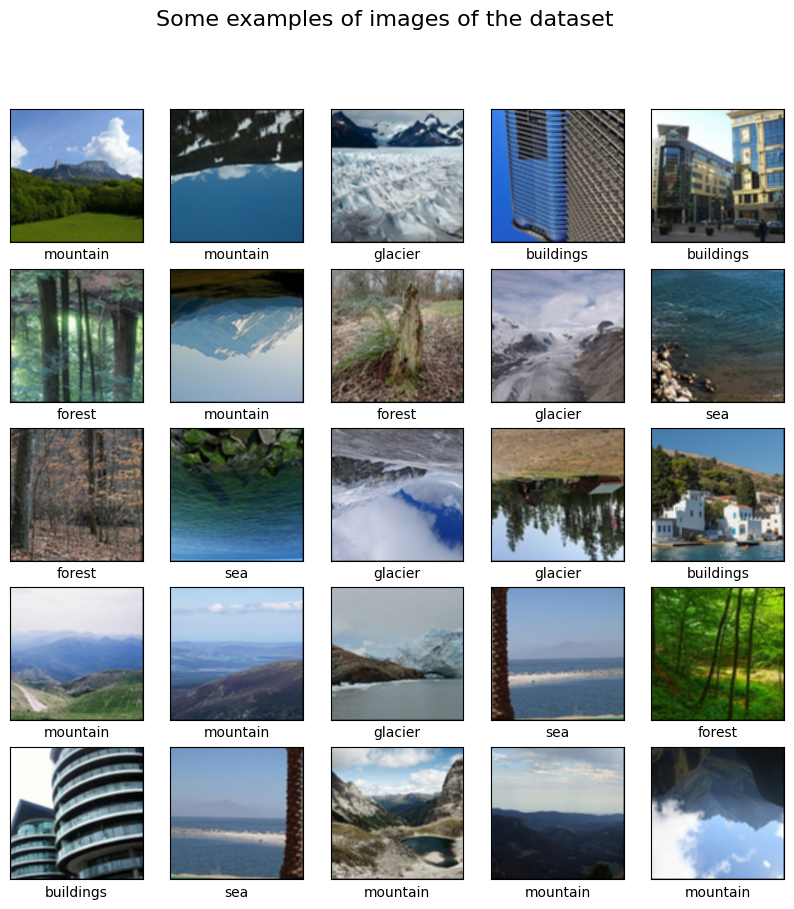

In [2]:
# 2 - Data Preprocessing

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 정규화 (0-1 범위)
def normalize(data):
    return data / 255.0

# 평균 필터
def average_filter(data):
    padded_data = np.pad(data, ((1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
    filtered_data = np.zeros_like(data)
    
    for i in range(1, padded_data.shape[0] - 1):
        for j in range(1, padded_data.shape[1] - 1):
            for k in range(padded_data.shape[2]):
                region = padded_data[i-1:i+2, j-1:j+2, k]
                filtered_data[i-1, j-1, k] = np.mean(region)
    
    return filtered_data

# 데이터 증강
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []
    
    for img, label in zip(images, labels):
        # Original
        augmented_images.append(img)
        augmented_labels.append(label)
        
        # Horizontal flip
        h_flip = cv2.flip(img, 1)
        augmented_images.append(h_flip)
        augmented_labels.append(label)
        
        # Vertical flip
        v_flip = cv2.flip(img, 0)
        augmented_images.append(v_flip)
        augmented_labels.append(label)
    
    return np.array(augmented_images), np.array(augmented_labels)

# 데이터 셔플링
def shuffle_data(images, labels):
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    return images[indices], labels[indices]

# 전처리 결과 확인
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)

    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

# 데이터 정규화
images_normalized = normalize(images)

# 평균 필터 적용
images_filtered = np.array([average_filter(img) for img in images_normalized])

# 데이터 증강 (3배)
images_augmented, labels_augmented = augment_data(images_filtered, labels)

# 데이터 셔플링
images_shuffled, labels_shuffled = shuffle_data(images_augmented, labels_augmented)

# 전처리된 데이터 형태 출력
print(f'Images size : {images_shuffled.shape}, dtype = {labels_shuffled.dtype}')

# 학습 셋과 테스트 셋으로 분리
X_train, X_test, y_train, y_test = train_test_split(images_shuffled, labels_shuffled, test_size=0.2, random_state=42)

print("=========================================================")

# 전처리된 훈련 및 테스트 데이터 형태 출력
print(f'Train Images size : {X_train.shape}, dtype = {X_train.dtype}')
print(f'Test Images size : {X_test.shape}, dtype = {X_test.dtype}')

print("=========================================================")

print(f'Train Labels size : {y_train.shape}, dtype = {y_train.dtype}')
print(f'Test Labels size : {y_test.shape}, dtype = {y_test.dtype}')

# 전처리된 데이터 일부 이미지 출력
class_names = {idx: name for name, idx in class_names_label.items()}
display_examples(class_names, images_shuffled, labels_shuffled)

In [10]:
# 3 - Model 구성 및 학습

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# CNN 모델 구성
def create_cnn_model(input_shape):
    model = tf.keras.Sequential([
        # 1'st convolutional layer
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0,2),
        
        # 2'nd convolutional layer
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        # Flatten and fully connected layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        # Output layer
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return model

input_shape = (150, 150, 3)  # 이미지 크기와 채널 수 (RGB)
model = create_cnn_model(input_shape)

# 모델 요약 출력
model.summary()

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer with custom learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 학습
history = model.fit(images_shuffled, labels_shuffled, epochs=30, batch_size=32, validation_split=0.2)

# 모델 파라미터 수 출력
total_params = model.count_params()
trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
non_trainable_params = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])

print(f'Total params: {total_params}')
print(f'Trainable params: {trainable_params}')
print(f'Non-trainable params: {non_trainable_params}')

model.summary()

# 모델 저장 경로 지정
save_path = 'C:/Coding/Python/machine_learning/term_project/models/2020144030_JMW.h5'

# 모델 저장
model.save('2020144030_JMW.h5')

print("모델이 '2020144030_JMW.h5' 파일로 저장되었습니다.")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 74, 74, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 36, 36, 32)       

c:\Users\jmw31\anaconda3\envs\ML\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


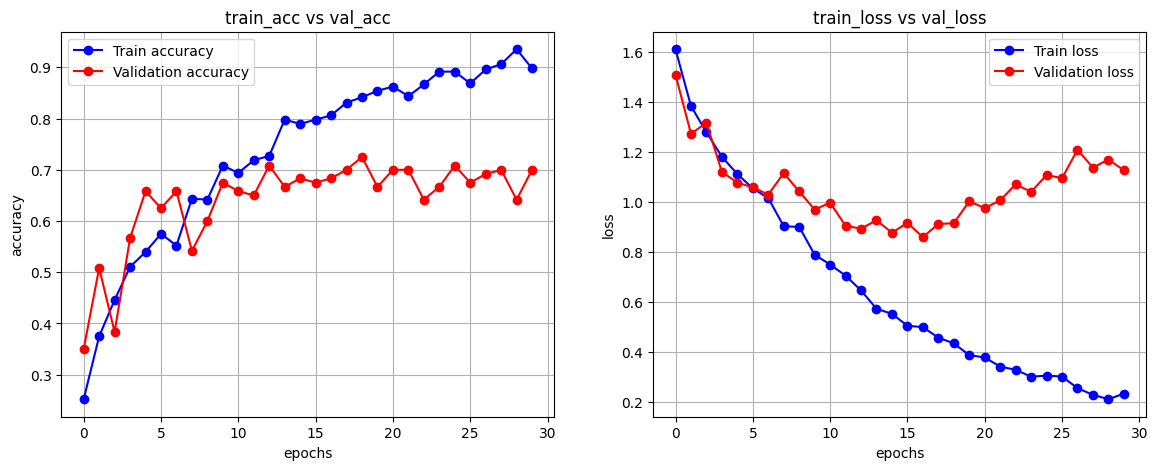

In [4]:
# 4 - 학습 결과 시각화

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Train accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('train_acc vs val_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Train loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.show()

test 데이터 로드 중


100%|██████████| 2/2 [00:00<00:00, 137.29it/s]

Test images data : (10, 150, 150, 3), dtype = float32
Test images category : (10,), dtype = int32


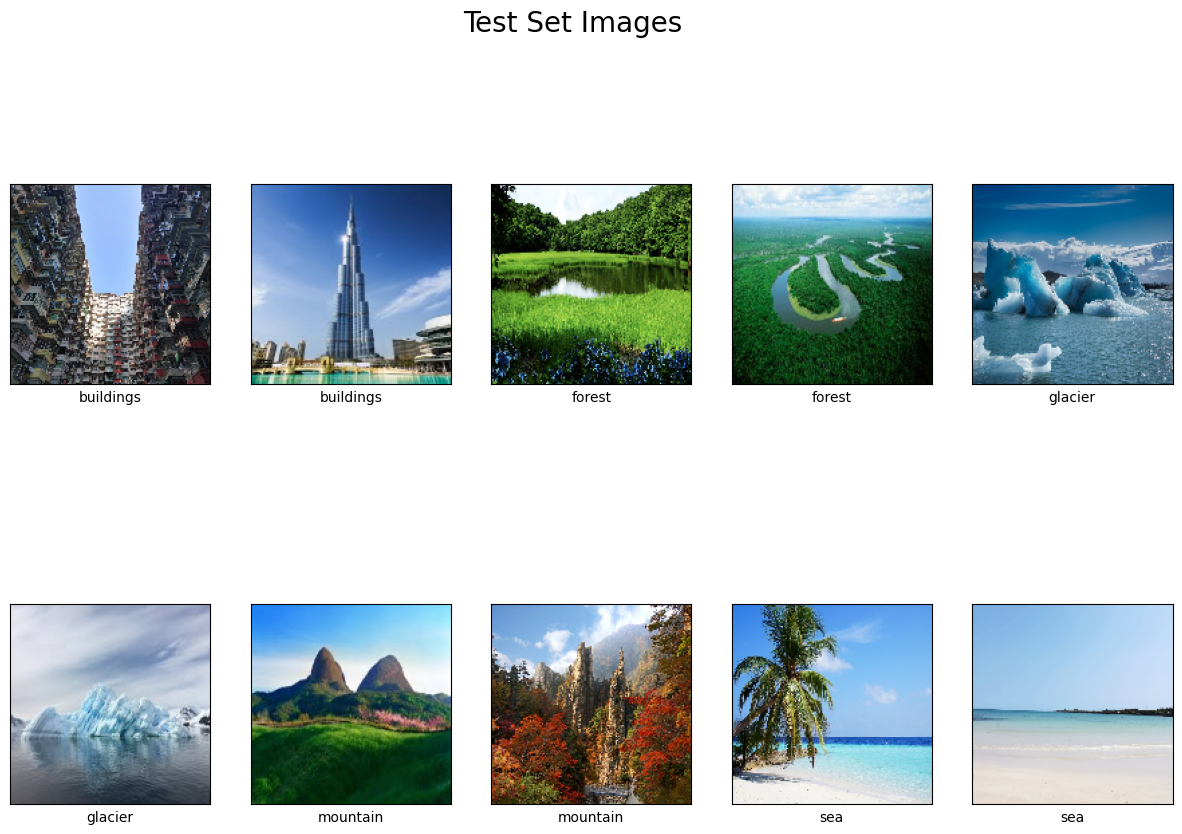

In [14]:
# 데이터 로드
def load_test_data(data_dir):
    dataset = 'test'
    images = []
    labels = []

    # 클래스 이름과 라벨을 얻기
    class_names_label = {name: idx for idx, name in enumerate(os.listdir(os.path.join(data_dir, dataset)))}

    print("{} 데이터 로드 중".format(dataset))

    dataset_path = os.path.join(data_dir, dataset)

    # 각 카테고리에 해당하는 폴더를 순회
    for folder in os.listdir(dataset_path):
        label = class_names_label[folder]

        # 폴더 안의 각 이미지를 순회
        folder_path = os.path.join(dataset_path, folder)
        for file in tqdm(os.listdir(folder_path)):
            # 이미지의 경로 이름을 얻기
            img_path = os.path.join(folder_path, file)

            # 이미지 열기 및 리사이즈
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # 이미지와 해당 라벨을 출력 리스트에 추가
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    return images, labels, class_names_label

# 이미지 출력
def plot_images(images, labels, class_names_label):
    class_names = {v: k for k, v in class_names_label.items()}
    plt.figure(figsize=(15, 10))
    plt.suptitle('Test Set Images', fontsize=20)  # 타이틀 추가
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].astype('uint8'))
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
# 데이터셋 경로 설정
data_dir = "C:/Coding/Python/machine_learning/term_project"

# 데이터 로드
test_images, test_labels, class_names_label = load_test_data(data_dir)

# 확인 출력
print(f'Test images data : {test_images.shape}, dtype = {test_images.dtype}')
print(f'Test images category : {test_labels.shape}, dtype = {test_labels.dtype}')

plot_images(test_images, test_labels, class_names_label)

In [18]:
# 6 - Model validation

from sklearn.metrics import accuracy_score

# 저장된 모델 불러오기
model_path = 'C:/Coding/Python/machine_learning/term_project/2020144030_JMW.h5'
model = tf.keras.models.load_model(model_path)

# 테스트 데이터 예측
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# 정확도 계산
accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

1/1 [==============================] - 0s 48ms/step
Test Accuracy: 60.00%
